Common_Model


In [36]:
"""
@author: Jiaxin Ye
@contact: jiaxin-ye@foxmail.com
"""
# -*- coding:UTF-8 -*-

import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
#from Model import TIMNET_Model
import argparse



In [37]:
"""
@author: Jiaxin Ye
@contact: jiaxin-ye@foxmail.com
"""

import sys

class Common_Model(object):

    def __init__(self, save_path: str = '', name: str = 'Not Specified'):
        self.model = None
        self.trained = False 

    def train(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError()

    def predict(self, samples):
        raise NotImplementedError()
        

    def predict_proba(self, samples):
        if not self.trained:
            sys.stderr.write("No Model.")
            sys.exit(-1)
        return self.model.predict_proba(samples)

    def save_model(self, model_name: str):
        raise NotImplementedError()

TIMNET


In [38]:
"""
@author: Jiaxin Ye
@contact: jiaxin-ye@foxmail.com
"""
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Activation, Lambda
from tensorflow.keras.layers import Conv1D, SpatialDropout1D,add,GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import sigmoid

def Temporal_Aware_Block(x, s, i, activation, nb_filters, kernel_size, dropout_rate=0, name=''):

    original_x = x
    #1.1
    conv_1_1 = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding='causal')(x)
    conv_1_1 = BatchNormalization(trainable=True,axis=-1)(conv_1_1)
    conv_1_1 =  Activation(activation)(conv_1_1)
    output_1_1 =  SpatialDropout1D(dropout_rate)(conv_1_1)
    # 2.1
    conv_2_1 = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding='causal')(output_1_1)
    conv_2_1 = BatchNormalization(trainable=True,axis=-1)(conv_2_1)
    conv_2_1 = Activation(activation)(conv_2_1)
    output_2_1 =  SpatialDropout1D(dropout_rate)(conv_2_1)
    
    if original_x.shape[-1] != output_2_1.shape[-1]:
        original_x = Conv1D(filters=nb_filters, kernel_size=1, padding='same')(original_x)
        
    output_2_1 = Lambda(sigmoid)(output_2_1)
    F_x = Lambda(lambda x: tf.multiply(x[0], x[1]))([original_x, output_2_1])
    return F_x


class TIMNET:
    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=None,
                 activation = "relu",
                 dropout_rate=0.1,
                 return_sequences=True,
                 name='TIMNET'):
        self.name = name
        self.return_sequences = return_sequences
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters

        self.supports_masking = True
        self.mask_value=0.

        if not isinstance(nb_filters, int):
            raise Exception()

    def __call__(self, inputs, mask=None):
        if self.dilations is None:
            self.dilations = 8
        forward = inputs
        backward = K.reverse(inputs,axes=1)
        
        print("Input Shape=",inputs.shape)
        forward_convd = Conv1D(filters=self.nb_filters,kernel_size=1, dilation_rate=1, padding='causal')(forward)
        backward_convd = Conv1D(filters=self.nb_filters,kernel_size=1, dilation_rate=1, padding='causal')(backward)
        
        final_skip_connection = []
        
        skip_out_forward = forward_convd
        skip_out_backward = backward_convd
        
        for s in range(self.nb_stacks):
            for i in [2 ** i for i in range(self.dilations)]:
                skip_out_forward = Temporal_Aware_Block(skip_out_forward, s, i, self.activation,
                                                        self.nb_filters,
                                                        self.kernel_size, 
                                                        self.dropout_rate,  
                                                        name=self.name)
                skip_out_backward = Temporal_Aware_Block(skip_out_backward, s, i, self.activation,
                                                        self.nb_filters,
                                                        self.kernel_size, 
                                                        self.dropout_rate,  
                                                        name=self.name)
                
                temp_skip = add([skip_out_forward, skip_out_backward],name = "biadd_"+str(i))
                temp_skip=GlobalAveragePooling1D()(temp_skip)
                temp_skip=tf.expand_dims(temp_skip, axis=1)
                final_skip_connection.append(temp_skip)

        output_2 = final_skip_connection[0]
        for i,item in enumerate(final_skip_connection):
            if i==0:
                continue
            output_2 = K.concatenate([output_2,item],axis=-2)
        x = output_2

        return x

In [39]:
from tensorflow.keras.layers import TimeDistributed


In [40]:
import matplotlib.pyplot as plt
import numpy as np

In [41]:
"""
@author: Jiaxin Ye
@contact: jiaxin-ye@foxmail.com
"""
import numpy as np
import tensorflow.keras.backend as K
import os
import tensorflow as tf
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Layer,Dense,Input
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
#from Common_Model import Common_Model
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import datetime
import pandas as pd

#from TIMNET import TIMNET


TIMNET_MODEL

In [42]:


def smooth_labels(labels, factor=0.1):
    # smooth the labels
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    return labels

class WeightLayer(Layer):
    def __init__(self, **kwargs):
        super(WeightLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[1],1),
                                      initializer='uniform',
                                      trainable=True)  
        super(WeightLayer, self).build(input_shape)  
 
    def call(self, x):
        tempx = tf.transpose(x,[0,2,1])
        x = K.dot(tempx,self.kernel)
        x = tf.squeeze(x,axis=-1)
        return  x
 
    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[2])
    
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    returnval = ex/K.sum(ex, axis=axis, keepdims=True)
    print("returnval is: ")
    print(returnval)
    return ex/K.sum(ex, axis=axis, keepdims=True)

class TIMNET_Model(Common_Model):
    def __init__(self, args, input_shape, class_label, **params):
        super(TIMNET_Model,self).__init__(**params)
        self.args = args
        self.data_shape = input_shape
        self.num_classes = len(class_label)
        self.class_label = class_label
        self.matrix = []
        self.eva_matrix = []
        self.acc = 0
        print("TIMNET MODEL SHAPE:",input_shape)
    
    def create_model(self):
        self.inputs=Input(shape = (self.data_shape[0],self.data_shape[1]))
        print(self.inputs.shape)
        self.multi_decision = TIMNET(nb_filters=self.args.filter_size,
                                kernel_size=self.args.kernel_size, 
                                nb_stacks=self.args.stack_size,
                                dilations=self.args.dilation_size,
                                dropout_rate=self.args.dropout,
                                activation = self.args.activation,
                                return_sequences=True, 
                                name='TIMNET')(self.inputs)
        
        #self.time_probs= TimeDistributed(Dense(self.num_classes, activation='softmax'))(self.multi_decision)
        self.decision = WeightLayer()(self.multi_decision)
        
        #self.time_probs= TimeDistributed(Dense(self.num_classes, activation='softmax'))(self.decision)
        self.predictions = Dense(self.num_classes, activation='softmax')(self.decision)
        self.model = Model(inputs = self.inputs, outputs = [ self.predictions])
        
        self.model.compile(loss = "categorical_crossentropy",
                           optimizer =Adam(learning_rate=self.args.lr, beta_1=self.args.beta1, beta_2=self.args.beta2, epsilon=1e-8),
                           metrics = ['accuracy'])
        print("Temporal create succes!")
        
   
   
    def test_one_sample(self, sample , framebyframe):
        # if audio is split to frames framebyframe must be True. 
        predictions = []
        self.create_model()
        path ='./Test_Models/RAVDE_46'
        weight_path= path+'/'+str(self.args.split_fold)+"-fold_weights_best_"+str(4)+".hdf5"
        self.model.load_weights(weight_path)
        if framebyframe:
            y_pred_best = self.model.predict(sample)  
            transposed_probabilities = np.transpose(y_pred_best)
            #for printing out each emotion probability graph seperately
            n_classes = len(self.class_label)
            fig, axes = plt.subplots(3, 3, figsize=(6, 6))  
            axes = axes.flatten()
            plt.suptitle("Emotion Probabilities")
            plt.xlabel('Samples')
            plt.ylabel('Probability')
            for i, class_name in enumerate(self.class_label):
                m = i % 3
                n = i / 3
                axes[i].plot(transposed_probabilities[i], label=class_name)
                axes[i].set_title(class_name)
                axes[i].set_ylim(0, 1)
                #axes[i].legend(False)
            plt.tight_layout() 
            plt.show()

            #for printing out emotions together. 
            colors = ["r", "c", "g", "y", "m", "b", "k", "orange"] 
            plt.figure(figsize=(10,6))
            for i, class_name in enumerate(self.class_label):
                plt.plot(np.arange(y_pred_best.shape[0]), transposed_probabilities[i], label=class_name, color=colors[i])
            plt.xlabel('Sample index')
            plt.ylabel('Probabilities')
            plt.legend() 
            plt.title('Emotion Probabilities for Each Class')
            plt.show()

        else: 
            y_pred_best = self.model.predict(np.expand_dims(sample, 0))
            print("y_predictions are: ")
            print(y_pred_best)
        
        
        return y_pred_best  

    def test_original(self, x, y, path, fold):
        i=1
        kfold = KFold(n_splits=self.args.split_fold, shuffle=True, random_state=self.args.random_seed)
        avg_accuracy = 0
        avg_loss = 0
        x_feats = []
        y_labels = []
        for train, test in kfold.split(x, y):
            self.create_model()
            weight_path=path+'/'+str(self.args.split_fold)+"-fold_weights_best_"+str(i)+".hdf5"
            self.model.fit(x[train], y[train],validation_data=(x[test],  y[test]),batch_size = 64,epochs = 0,verbose=0)
            self.model.load_weights(weight_path)#+source_name+'_single_best.hdf5')
            best_eva_list = self.model.evaluate(x[test],  y[test])
        
            avg_loss += best_eva_list[0]
            avg_accuracy += best_eva_list[1]
            print(str(i)+'_Model evaluation: ', best_eva_list,"   Now ACC:",str(round(avg_accuracy*10000)/100/i))
            i+=1
            y_pred_best = self.model.predict(x[test]) #burası
        
            transposed_probabilities = np.transpose(y_pred_best)
            
            # for i, class_name in enumerate(self.class_label):
            #     plt.plot(transposed_probabilities[i], label=class_name)
            #     plt.xlabel('Samples')
            #     plt.ylabel('Probability')
            #     plt.title('Emotion Probabilities')
            #     plt.legend()
            #     plt.show()
            
            self.matrix.append(confusion_matrix(np.argmax(y[test],axis=1),np.argmax(y_pred_best,axis=1)))
            em = classification_report(np.argmax(y[test],axis=1),np.argmax(y_pred_best,axis=1), target_names=self.class_label,output_dict=True)
            self.eva_matrix.append(em)
            print(classification_report(np.argmax(y[test],axis=1),np.argmax(y_pred_best,axis=1), target_names=self.class_label))
            caps_layer_model = Model(inputs=self.model.input,
            outputs=self.model.get_layer(index=-2).output)
            feature_source = caps_layer_model.predict(x[test])
            x_feats.append(feature_source)
            y_labels.append(y[test])
            
        print("Average ACC:",avg_accuracy/self.args.split_fold)
        self.acc = avg_accuracy/self.args.split_fold
        
        return x_feats, y_labels



    def test(self, x, y, path):
        i=1
        kfold = KFold(n_splits=self.args.split_fold, shuffle=True, random_state=self.args.random_seed)
        avg_accuracy = 0
        avg_loss = 0
        x_feats = []
        y_labels = []
        for train, test in kfold.split(x, y):
            self.create_model()
            weight_path=path+'/'+str(self.args.split_fold)+"-fold_weights_best_"+str(i)+".hdf5"
            self.model.fit(x[train], y[train],validation_data=(x[test][0],  y[test][0]),batch_size = 64,epochs = 0,verbose=0)
            self.model.load_weights(weight_path)#+source_name+'_single_best.hdf5')
            best_eva_list = self.model.evaluate(np.expand_dims(x[test][0], 0), np.expand_dims(y[test][0], 0))
            #best_eva_list = self.model.evaluate(x[test][0],  y[test][0])
            x_test = x[test]
            x_test0 = x_test[0]
            avg_loss += best_eva_list[0]
            avg_accuracy += best_eva_list[1]
            print(str(i)+'_Model evaluation: ', best_eva_list,"   Now ACC:",str(round(avg_accuracy*10000)/100/i))
            i+=1
            y_pred_best = self.model.predict(np.expand_dims(x[test][0], 0)) #burası
            print("y_pred_best is: ")
            print(y_pred_best)
            print(y[test][0])
            break
        return x_feats, y_labels
    

    def train(self, x, y):

        filepath = self.args.model_path
        resultpath = self.args.result_path

        if not os.path.exists(filepath):
            os.mkdir(filepath)
        if not os.path.exists(resultpath):
            os.mkdir(resultpath)

        i=1
        now = datetime.datetime.now()
        now_time = datetime.datetime.strftime(now,'%Y-%m-%d_%H-%M-%S')
        kfold = KFold(n_splits=self.args.split_fold, shuffle=True, random_state=self.args.random_seed)
        avg_accuracy = 0
        avg_loss = 0
        for train, test in kfold.split(x, y):
            self.create_model()
            y[train] = smooth_labels(y[train], 0.1)
            folder_address = filepath+self.args.data+"_"+str(self.args.random_seed)+"_"+now_time
            if not os.path.exists(folder_address):
                os.mkdir(folder_address)
            weight_path=folder_address+'/'+str(self.args.split_fold)+"-fold_weights_best_"+str(i)+".hdf5"
            checkpoint = callbacks.ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1,save_weights_only=True,save_best_only=True,mode='max')
            max_acc = 0
            best_eva_list = []
            h = self.model.fit(x[train], y[train],validation_data=(x[test],  y[test]),batch_size = self.args.batch_size, epochs = self.args.epoch, verbose=1,callbacks=[checkpoint])
            self.model.load_weights(weight_path)
            best_eva_list = self.model.evaluate(x[test],  y[test])
            avg_loss += best_eva_list[0]
            avg_accuracy += best_eva_list[1]
            print(str(i)+'_Model evaluation: ', best_eva_list,"   Now ACC:",str(round(avg_accuracy*10000)/100/i))
            i+=1
            y_pred_best = self.model.predict(x[test])
            self.matrix.append(confusion_matrix(np.argmax(y[test],axis=1),np.argmax(y_pred_best,axis=1)))
            em = classification_report(np.argmax(y[test],axis=1),np.argmax(y_pred_best,axis=1), target_names=self.class_label,output_dict=True)
            self.eva_matrix.append(em)
            print(classification_report(np.argmax(y[test],axis=1),np.argmax(y_pred_best,axis=1), target_names=self.class_label))

        print("Average ACC:",avg_accuracy/self.args.split_fold)
        self.acc = avg_accuracy/self.args.split_fold
        writer = pd.ExcelWriter(resultpath+self.args.data+'_'+str(self.args.split_fold)+'fold_'+str(round(self.acc*10000)/100)+"_"+str(self.args.random_seed)+"_"+now_time+'.xlsx')
        for i,item in enumerate(self.matrix):
            temp = {}
            temp[" "] = self.class_label
            for j,l in enumerate(item):
                temp[self.class_label[j]]=item[j]
            data1 = pd.DataFrame(temp)
            data1.to_excel(writer,sheet_name=str(i), encoding='utf8')

            df = pd.DataFrame(self.eva_matrix[i]).transpose()
            df.to_excel(writer,sheet_name=str(i)+"_evaluate", encoding='utf8')
        writer.save()
        writer.close()

        K.clear_session()
        self.matrix = []
        self.eva_matrix = []
        self.acc = 0
        self.trained = True



Librosa


In [43]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

In [44]:
audio3 = './wav/03a01Fa.wav' #Freude(Happy)

In [45]:
audioçınar = './mutlu.wav'

In [46]:
ipd.Audio(audio3)

In [47]:
def display_mfccs(mfccs):
    plt.figure(figsize= (10,4))
    librosa.display.specshow(mfccs, x_axis = "time" )
    plt.colorbar(format = "%+2.0f ")
    plt.show

In [48]:
def get_framed(signalpath,frame_length, skip_length):
    y, sr = librosa.load(signalpath)
    frame_length_samples = int(frame_length * sr)
    skip_length_samples = int(skip_length * sr)

    frames = []

    for i in range(0, len(y) - frame_length_samples, skip_length_samples):
        frame = y[i:i+frame_length_samples]
        frames.append(frame)
    return frames,sr
    

In [49]:

def get_feature_frompath(file_path = str , mfcc_len: int = 39, mean_signal_length: int = 110000):
  	  ## """
      ## file_path: Speech signal folder
      ##mfcc_len: MFCC coefficient length
      ##mean_signal_length: MFCC feature average length
  	  ##"""
      
    signal, fs = librosa.load(file_path)
    s_len = len(signal)

    if s_len < mean_signal_length:
        pad_len = mean_signal_length - s_len
        pad_rem = pad_len % 2
        pad_len //= 2
        signal = np.pad(signal, (pad_len, pad_len + pad_rem), 'constant', constant_values = 0)
    else:
        pad_len = s_len - mean_signal_length
        pad_len //= 2
        signal = signal[pad_len:pad_len + mean_signal_length]
    mfcc = librosa.feature.mfcc(y=signal, sr=fs, n_mfcc=39)
    mfcc = mfcc.T
    feature = mfcc
    return feature

In [50]:
def get_feature_fromsignal(signal , fs, mfcc_len: int = 39, mean_signal_length: int = 110000):
  	  ## """
      ## file_path: Speech signal folder
      ##mfcc_len: MFCC coefficient length
      ##mean_signal_length: MFCC feature average length
  	  ##"""
      
    s_len = len(signal)
    
    if s_len < mean_signal_length:
        pad_len = mean_signal_length - s_len
        pad_rem = pad_len % 2
        pad_len //= 2
        signal = np.pad(signal, (pad_len, pad_len + pad_rem), 'constant', constant_values = 0)
    else:
        pad_len = s_len - mean_signal_length
        pad_len //= 2
        signal = signal[pad_len:pad_len + mean_signal_length]
    mfcc = librosa.feature.mfcc(y=signal, sr=fs, n_mfcc=39)
    mfcc = mfcc.T
    feature = mfcc
    return feature

In [51]:
def get_features_fromframes(signalpath,frame_length,skip_length):
    frames, sr = get_framed(signalpath,frame_length,skip_length)
    mfccs = [get_feature_fromsignal(frame,sr) for frame in frames]   
    mfccs_np = np.stack(mfccs) 
    return mfccs_np

AUDIO_FILES

In [52]:
calm_ravde13 =  './Audio_Speech_Actors_01-24/Actor_13/03-01-02-02-02-01-13.wav'  #calm, male

In [53]:
angry_ravde13 = './Audio_Speech_Actors_01-24/Actor_13/03-01-05-02-02-01-13.wav'  #angry, male

In [54]:
happy_ravde3 = './Audio_Speech_Actors_01-24/Actor_03/03-01-03-01-01-01-03.wav' #happy #male

In [55]:
disgust_ravde2 = './Audio_Speech_Actors_01-24/Actor_02/03-01-07-02-01-02-02.wav' #disgust,female

In [56]:
angry_ravde2 = './Audio_Speech_Actors_01-24/Actor_02/03-01-05-02-01-02-02.wav' #angry female

In [57]:
calm_ravde2 = './Audio_Speech_Actors_01-24/Actor_02/03-01-02-02-01-02-02.wav' #angry female

In [58]:
calm_ravde18 = './Audio_Speech_Actors_01-24/Actor_18/03-01-02-01-01-02-18.wav' #calm #female

Concatenate

In [59]:
import soundfile as sf

In [60]:
#CONCATENATION OF TWO FILES
y1, sr1 = librosa.load(calm_ravde13)
y2, sr2 = librosa.load(angry_ravde13)

assert sr1 == sr2, "Sample rates (sr) must be the same to concatenate the audios."

y = np.concatenate([y1, y2])
sf.write('combined_audio(calm-angry).wav', y, sr1)


In [61]:
y1, sr1 = librosa.load(angry_ravde2)
y2, sr2 = librosa.load(disgust_ravde2)

assert sr1 == sr2, "Sample rates (sr) must be the same to concatenate the audios."

y = np.concatenate([y1, y2])
sf.write('combined_audio(angry-disgust).wav', y, sr1)

In [62]:
y1, sr1 = librosa.load('combined_audio(angry-disgust).wav')
y2, sr2 = librosa.load(calm_ravde2)

assert sr1 == sr2, "Sample rates (sr) must be the same to concatenate the audios."

y = np.concatenate([y1, y2])
sf.write('combined_audio(angry-disgust-calm).wav', y, sr1)

In [63]:
ipd.Audio('./combined_audio(angry-disgust-calm).wav')

In [64]:
mfccs_combined = get_features_fromframes('./combined_audio(angry-disgust-calm).wav', 4.0,0.05)

In [65]:
mfccs_combined = get_features_fromframes('./combined_audio(calm-angry).wav', 3.0,0.05)

MAIN

x_source shape is: 
(1440, 215, 39)
TIMNET MODEL SHAPE: (215, 39)
(None, 215, 39)
Input Shape= (None, 215, 39)
Temporal create succes!
3/3 [==============================] - 1s 19ms/step


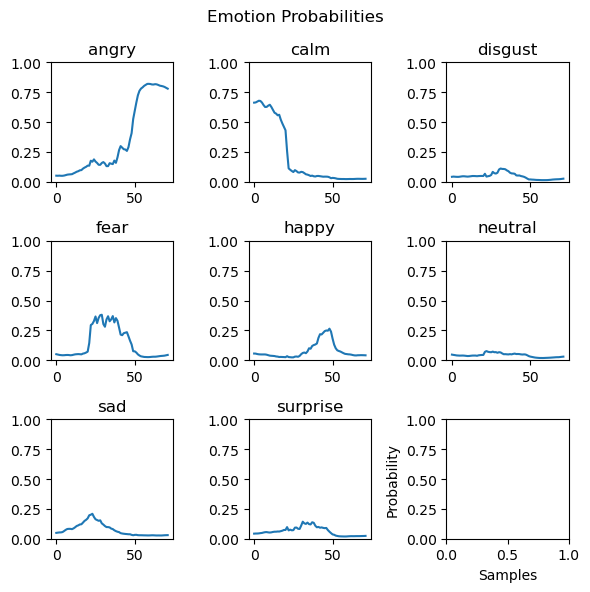

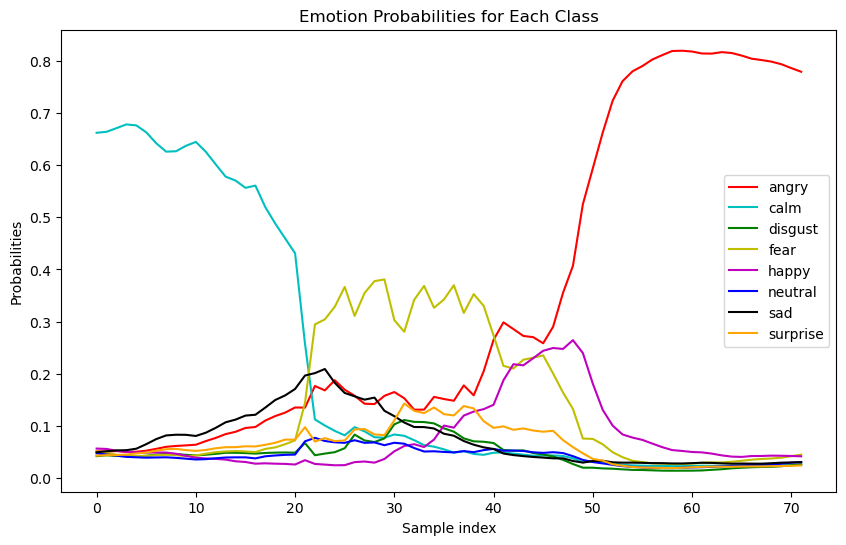

In [66]:

parser = argparse.ArgumentParser()

parser.add_argument('--mode', type=str, default="test")
parser.add_argument('--model_path', type=str, default='./Models/')
parser.add_argument('--result_path', type=str, default='./Results/')
parser.add_argument('--test_path', type=str, default='./Test_Models/EMODB_46')
parser.add_argument('--data', type=str, default='RAVDE')
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--beta1', type=float, default=0.93)
parser.add_argument('--beta2', type=float, default=0.98)
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--epoch', type=int, default=60)
parser.add_argument('--dropout', type=float, default=0.1)
parser.add_argument('--random_seed', type=int, default=46)
parser.add_argument('--activation', type=str, default='relu')
parser.add_argument('--filter_size', type=int, default=39)
parser.add_argument('--dilation_size', type=int, default=8)# If you want to train model on IEMOCAP, you should modify this parameter to 10 due to the long duration of speech signals.
parser.add_argument('--kernel_size', type=int, default=2)
parser.add_argument('--stack_size', type=int, default=1)
parser.add_argument('--split_fold', type=int, default=10)
#parser.add_argument('--gpu', type=str, default='0')

dataset_paths = {
    "EMODB": './Test_Models/EMODB_46',
    "CASIA": './Test_Models/CASIA_32',
    "EMOVO": './Test_Models/EMOVO_1',
    "IEMOCAP" : './Test_Models/IEMOCAP_16',
    "RAVDE" : './Test_Models/RAVDE_46',
    "SAVEE" : './Test_Models/SAVEE_44',
}


args = parser.parse_args('--mode test --model_path ./Models/ --result_path ./Results/ --test_path ./Test_Models/RAVDE_46 --data RAVDE --lr 0.001 --beta1 0.93 --beta2 0.98 --batch_size 64 --epoch 60 --dropout 0.1 --random_seed 46 --activation relu --filter_size 39 --dilation_size 8 --kernel_size 2 --stack_size 1 --split_fold 10'.split())

if args.data=="IEMOCAP" and args.dilation_size!=10:
    args.dilation_size = 10
    print("IEMOCAP")
    
#os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
#gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth=True 
#session = tf.compat.v1.Session(config=config)
#print(f"###gpus:{gpus}")

CLASS_LABELS_finetune = ("angry", "fear", "happy", "neutral","sad")
CASIA_CLASS_LABELS = ("angry", "fear", "happy", "neutral", "sad", "surprise")#CASIA
EMODB_CLASS_LABELS = ("angry", "boredom", "disgust", "fear", "happy", "neutral", "sad")#EMODB
SAVEE_CLASS_LABELS = ("angry","disgust", "fear", "happy", "neutral", "sad", "surprise")#SAVEE
RAVDE_CLASS_LABELS = ("angry", "calm", "disgust", "fear", "happy", "neutral","sad","surprise")#rav
IEMOCAP_CLASS_LABELS = ("angry", "happy", "neutral", "sad")#iemocap
EMOVO_CLASS_LABELS = ("angry", "disgust", "fear", "happy","neutral","sad","surprise")#emovo
CLASS_LABELS_dict = {"CASIA": CASIA_CLASS_LABELS,
               "EMODB": EMODB_CLASS_LABELS,
               "EMOVO": EMOVO_CLASS_LABELS,
               "IEMOCAP": IEMOCAP_CLASS_LABELS,
               "RAVDE": RAVDE_CLASS_LABELS,
               "SAVEE": SAVEE_CLASS_LABELS}


data = np.load("./MFCC/"+args.data+".npy",allow_pickle=True).item()
x_source = data["x"]
y_source = data["y"]

#print(data.keys())
#print(x_source[0].shape)
# x_one = x_source[0]
print("x_source shape is: ")
print(x_source.shape)
# print("x_one shape is: ")
# print(x_one.shape)
# y_one = y_source[0]

CLASS_LABELS = CLASS_LABELS_dict[args.data]

#print(x_source.shape)
#print(y_source.shape)

model = TIMNET_Model(args=args, input_shape=x_source.shape[1:], class_label=CLASS_LABELS)
if args.mode=="train":
    model.train(x_source, y_source)
elif args.mode=="test":
    #x_feats, y_labels = model.test(x_source, y_source, path=args.test_path)
    #x_feats, y_labels = model.test_original(x_source, y_source, path=args.test_path, fold = 1)# x_feats and y_labels are test datas for t-sne
    predictions  = model.test_one_sample(mfccs_combined,True)
    